In [1]:
import os
os.environ['OPENBLAS_NUM_THREADS'] = '20'
import sys
sys.path.append('../')

import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import scipy as sp
#import colorcet as cc
import matplotlib.pyplot as plt
import libpysal as lps
import random
from matplotlib import rcParams
import seaborn as sns

sc.set_figure_params(
    scanpy=True, dpi_save=600, vector_friendly=True, format="pdf",
    facecolor=(1.0, 1.0, 1.0, 0.0), transparent=False
)
rcParams["savefig.bbox"] = "tight"

/mnt/atlas_local/chaozhong/home/miniconda3/envs/multiome/lib/python3.10/site-packages/libpysal/weights/util.py:23: UserWarning: geopandas not available. Some functionality will be disabled.
  warn("geopandas not available. Some functionality will be disabled.")


In [2]:
anndat_multiome = ad.read_h5ad('../data/10XMultiome/10XPBMC.all.pseudo.h5ad')

First implement the core function to calculate Local L for marker discovery.

In [ ]:
import multiome.graph_measure as gm
anndat_multiome = gm.Morans_I(anndat_multiome)

/mnt/atlas_local/chaozhong/home/miniconda3/envs/multiome/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  warnings.warn(message)


### Find all markers

In [4]:
import multiome.marker_discovery as md
anndat_multiome, stat_df_all = md.FindAllMarkers(anndat_multiome,
                                                 ident = 'seurat_annotations',
                                                 corrct_method='bonferroni',
                                                 seed=1) #11075

No previously calculated per group L matrix found, will calculate the matrix with default parameters...
It's highly recommended to run the per group Local L calculation first with fine-tuned parameters.
Filtering features by Moran's I and feature sparsity in single-cell data...
Previously calculated Moran's I found.
Keep features with Moran's I > 0.4 and at least 5.0% expressed in single-cell data...
13761 pairs left for graph-based correlation L calculation.

Calculating local graph-based correlation value...
Set L to 0 for cells with no expression on either feature of a certain pair...
Following changes made to the AnnData object:
	Graph-based Pearson Correlation results saved in uns['Local_L_by_seurat_annotations']
	uns['peaks_nearby']['Local_L_by_seurat_annotations'] added indicates feature selected for per group local L calculation or not.
========= Finished ========
Performing statistical test for correlation differences among clusters...
Completed! 77.36s past.


Text(0, 0.5, '#Gene-Peak Pairs')

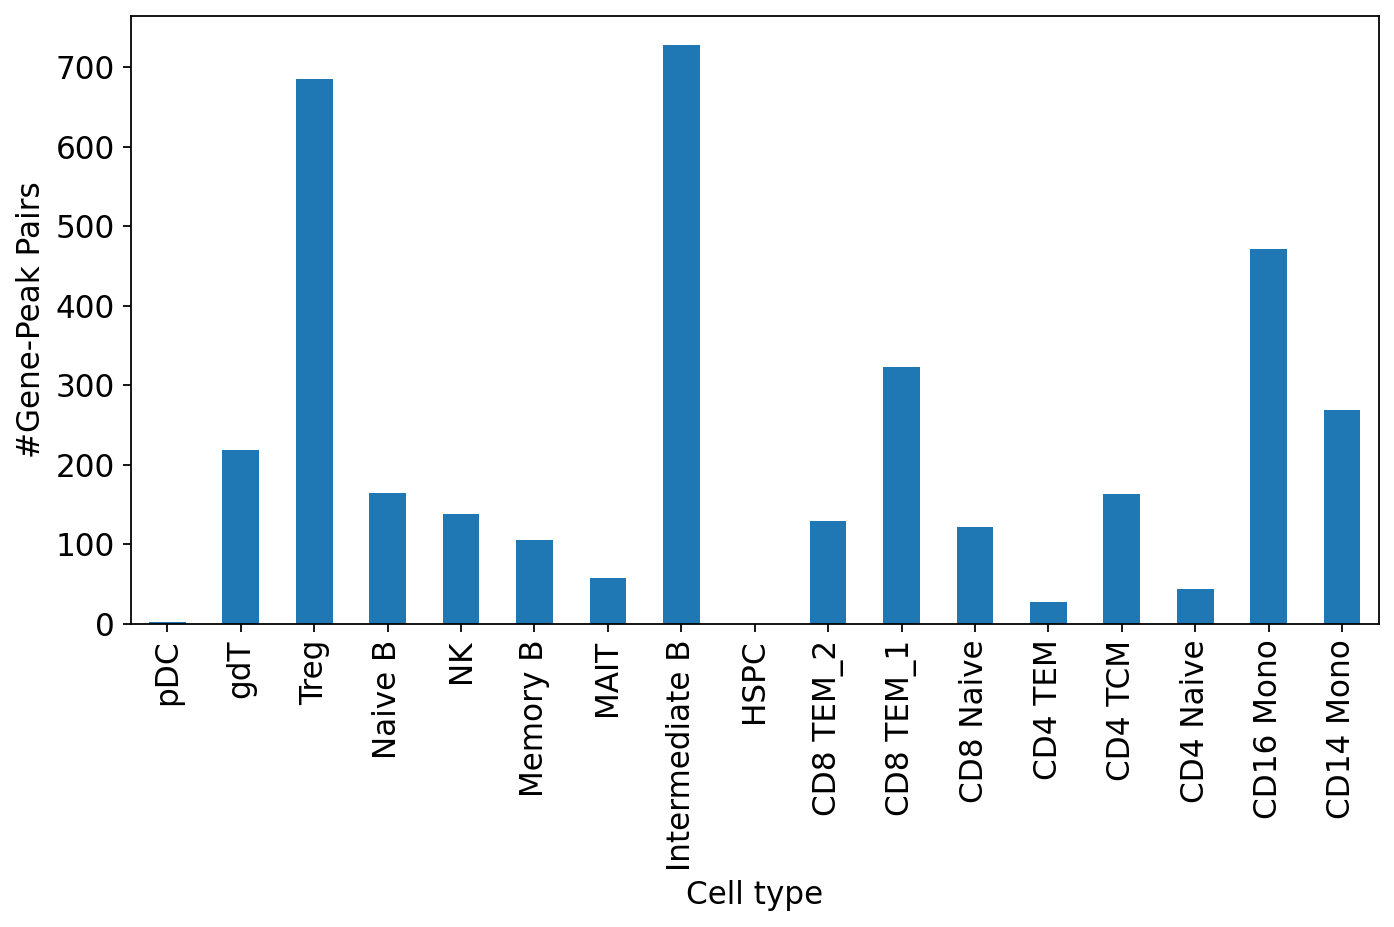

In [5]:
stat_df_all['score.abs'] = np.abs(stat_df_all['score'])
stat_df_all = stat_df_all.sort_values(by=['group','score.abs'], ascending=False)
stat_df_all.to_csv('PBMC.AllMarker.csv')

stat_df_all_tmp = stat_df_all.loc[stat_df_all['group']!='cDC']

summary_bar_df = pd.DataFrame(np.empty((len(stat_df_all_tmp['group'].unique()),2)))
summary_bar_df.iloc[:,0] = stat_df_all_tmp['group'].unique()
marker_list = []
for i in range(summary_bar_df.shape[0]):
    stat_df_sub = stat_df_all_tmp.loc[stat_df_all_tmp['group']==summary_bar_df.iloc[i,0],:]
    stat_df_sub = md.MarkerFilter(stat_df_sub,
                                  min_pct_rna=0.1,
                                  min_pct_atac=0.05,
                                  mean_diff=0.2,
                                  p_cutoff=1e-6,
                                  plot=False)
    
    stat_df_sub = stat_df_sub.sort_values(by='Mean.1', ascending=False)
    
    summary_bar_df.iloc[i,1] = stat_df_sub.shape[0]
    marker_list += stat_df_sub['name'].tolist()
ax = summary_bar_df.plot.bar(x=0, y=1, grid=False, figsize=(10, 5))
ax.get_legend().remove()
plt.xlabel('Cell type')
plt.ylabel('#Gene-Peak Pairs')

/mnt/atlas_local/chaozhong/data/thesis/multiome/visualization.py:70: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  anndat_L = ad.AnnData(


         Falling back to preprocessing with `sc.pp.pca` and default params.


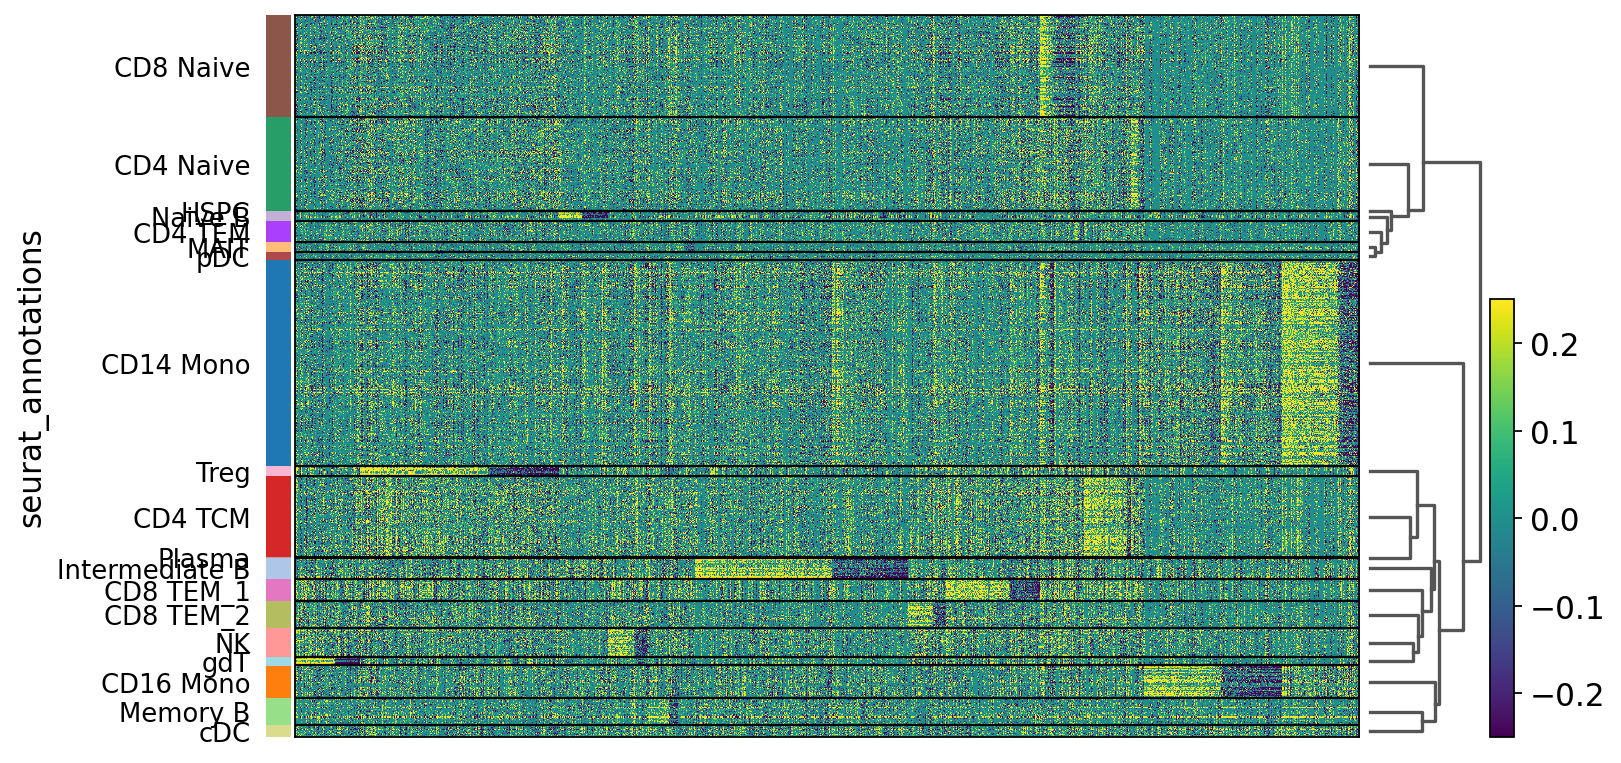

In [6]:
import multiome.visualization as mv

#marker_list = np.unique(marker_list)
mv.LocalL_Heatmap_nocluster(anndat_multiome, pairs=marker_list,
                  groupby='seurat_annotations',
                  ident='seurat_annotations',
                  vmin=-0.25, vmax=0.25, dendrogram=True, figsize=(10,6))

### Intermediate B v.s. Memory B

In [4]:
import multiome.marker_discovery as md
anndat_multiome, stat_df_all = md.FindMarkers(anndat_multiome,
                                              ident = 'seurat_annotations',
                                              group_1 = 'Memory B',
                                              group_2 = 'Intermediate B',
                                              corrct_method='bonferroni',
                                              seed=1) #11075

No previously calculated per group L matrix found, will calculate the matrix with default parameters...
It's highly recommended to run the per group Local L calculation first with fine-tuned parameters.
Filtering features by Moran's I and feature sparsity in single-cell data...
Previously calculated Moran's I found.
Keep features with Moran's I > 0.4 and at least 5.0% expressed in single-cell data...
13761 pairs left for graph-based correlation L calculation.

Calculating local graph-based correlation value...
Set L to 0 for cells with no expression on either feature of a certain pair...
Following changes made to the AnnData object:
	Graph-based Pearson Correlation results saved in uns['Local_L_by_seurat_annotations']
	uns['peaks_nearby']['Local_L_by_seurat_annotations'] added indicates feature selected for per group local L calculation or not.
========= Finished ========
Perform statistical test for correlation differences between selected two group...
Completed! 3.59s past.


In [5]:
stat_df_all['score.abs'] = np.abs(stat_df_all['score'])
stat_df_all = stat_df_all.sort_values(by=['group','score.abs'], ascending=False)
stat_df_all.to_csv('10X_B.markers.csv')

stat_df_all_tmp = stat_df_all.loc[stat_df_all['group']!='cDC']

summary_bar_df = pd.DataFrame(np.empty((len(stat_df_all_tmp['group'].unique()),2)))
summary_bar_df.iloc[:,0] = stat_df_all_tmp['group'].unique()
marker_list = []
for i in range(summary_bar_df.shape[0]):
    stat_df_sub = stat_df_all_tmp.loc[stat_df_all_tmp['group']==summary_bar_df.iloc[i,0],:]
    stat_df_sub = md.MarkerFilter(stat_df_sub,
                                  min_pct_rna=0.1,
                                  min_pct_atac=0.05,
                                  mean_diff=0.2,
                                  p_cutoff=1e-6,
                                  plot=False)
    
    stat_df_sub = stat_df_sub.sort_values(by='Mean.1', ascending=False)
    
    summary_bar_df.iloc[i,1] = stat_df_sub.shape[0]
    marker_list += stat_df_sub['name'].tolist()

         Falling back to preprocessing with `sc.pp.pca` and default params.


/mnt/atlas_local/chaozhong/data/thesis/multiome/visualization.py:24: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  anndat_L = ad.AnnData(
/mnt/atlas_local/chaozhong/home/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


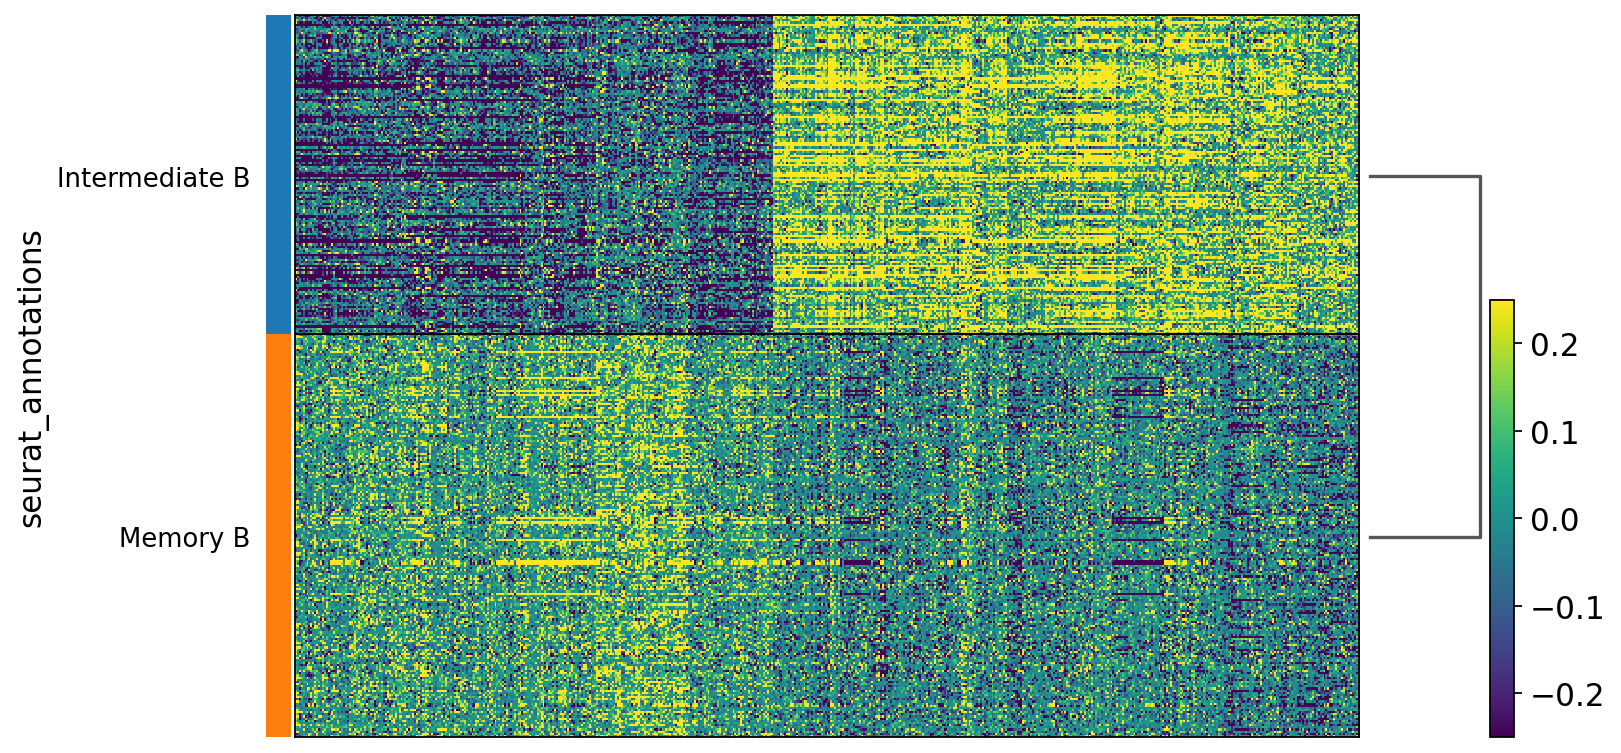

In [6]:
import multiome.visualization as mv

anndat_B = anndat_multiome[anndat_multiome.obs['seurat_annotations'].isin(['Memory B','Intermediate B'])].copy()
anndat_B.uns['Local_L_by_seurat_annotations'] = anndat_B.uns['Local_L_by_seurat_annotations'][anndat_multiome.obs['seurat_annotations'].isin(['Memory B','Intermediate B']).tolist(),:]

marker_list = np.unique(marker_list)
mv.LocalL_Heatmap(anndat_B,
                  pairs=marker_list,
                  groupby='seurat_annotations',
                  ident='seurat_annotations',
                  save='figure4A.pdf',
                  vmin=-0.25, vmax=0.25, dendrogram=True, figsize=(10,6))


### CD4+ T cells differentiation

In [3]:
anndat_multiome = anndat_multiome[anndat_multiome.obs['seurat_annotations'].isin(['CD4 Naive','CD4 TEM','CD4 TCM'])]

In [4]:
import multiome.graph_measure as gm
anndat_multiome = gm.Morans_I(anndat_multiome)

/mnt/atlas_local/chaozhong/home/miniconda3/envs/multiome/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/mnt/atlas_local/chaozhong/data/thesis/multiome/graph_measure.py:38: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  anndat_multiome.var['Morans.I'] = np.NaN


Following changes made to the AnnData object:
	Moran's I value saved in var['Morans.I']
7.418s past


/mnt/atlas_local/chaozhong/data/thesis/multiome/moran_vec.py:125: RuntimeWarning: invalid value encountered in true_divide
  return self.n / self.w.s0 * (inum / z2ss)


In [5]:
anndat_multiome = gm.Local_L_bygroup(anndat_multiome, groupby='seurat_annotations',
                                     I_cutoff=0.3, pct_cutoff=0.05,
                                     dropout_rm=True,
                                     permutations=0, seed=1, max_RAM=16)

Filtering features by Moran's I and feature sparsity in single-cell data...
Previously calculated Moran's I found.
Keep features with Moran's I > 0.3 and at least 5.0% expressed in single-cell data...
4530 pairs left for graph-based correlation L calculation.

Calculating local graph-based correlation value...
Set L to 0 for cells with no expression on either feature of a certain pair...
Following changes made to the AnnData object:
	Graph-based Pearson Correlation results saved in uns['Local_L_by_seurat_annotations']
	uns['peaks_nearby']['Local_L_by_seurat_annotations'] added indicates feature selected for per group local L calculation or not.


In [6]:
import multiome.marker_discovery as md
anndat_multiome, stat_df_all = md.FindAllMarkers(anndat_multiome,
                                                 ident = 'seurat_annotations',
                                                 corrct_method='bonferroni',
                                                 seed=1) #11075

Previously calculated per group L matrix found, will use it for marker discovery.
Performing statistical test for correlation differences among clusters...
Completed! 2.78s past.


In [7]:
stat_df_all['score.abs'] = np.abs(stat_df_all['score'])
stat_df_all = stat_df_all.sort_values(by=['group','score.abs'], ascending=False)
stat_df_all.to_csv('10X_CD4T.markers.csv')
stat_df_all_tmp = stat_df_all.copy()

summary_bar_df = pd.DataFrame(np.empty((len(stat_df_all_tmp['group'].unique()),2)))
summary_bar_df.iloc[:,0] = stat_df_all_tmp['group'].unique()
marker_list = []
#summary_bar_df

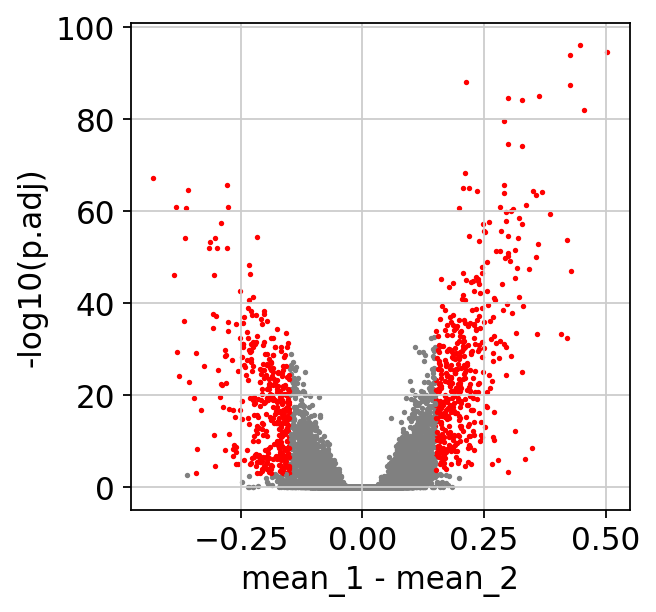

In [8]:
for i in range(summary_bar_df.shape[0]):
    stat_df_sub = stat_df_all_tmp.loc[stat_df_all_tmp['group']==summary_bar_df.iloc[i,0],:]
    stat_df_sub = md.MarkerFilter(stat_df_sub,
                                  min_pct_rna=0.1,
                                  min_pct_atac=0.05,
                                  mean_diff=0.15,
                                  p_cutoff=1e-3,
                                  plot=True)
    
    stat_df_sub = stat_df_sub.sort_values(by='Mean.1', ascending=False)
    
    summary_bar_df.iloc[i,1] = stat_df_sub.shape[0]
    marker_list += stat_df_sub['name'].tolist()
#ax = summary_bar_df.plot.bar(x=0, y=1, grid=False, figsize=(10, 5))
#ax.get_legend().remove()
#plt.xlabel('Cell type')
#plt.ylabel('#Gene-Peak Pairs')

In [9]:
summary_bar_df

0      1
0    CD4 TEM  132.0
1    CD4 TCM  419.0
2  CD4 Naive  290.0

In [11]:
import multiome.visualization as mv

marker_list = np.unique(marker_list)
mv.LocalL_Heatmap(anndat_multiome,
                  pairs=marker_list,
                  groupby='seurat_annotations',
                  ident='seurat_annotations',
                  save='figure4B.pdf',
                  vmin=-0.2, vmax=0.2, dendrogram=True, figsize=(10,6))


         Falling back to preprocessing with `sc.pp.pca` and default params.


/mnt/atlas_local/chaozhong/data/thesis/multiome/visualization.py:24: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  anndat_L = ad.AnnData(
/mnt/atlas_local/chaozhong/home/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


In [21]:
import multiome.functional_anno as functional_anno

In [23]:
peaks = [f.split('_')[1] for f in marker_list]
print(len(peaks))
homer_df = functional_anno.run_HOMER_motif(peaks, out_dir='homer/',
                                           prefix='CD4T', ref_genome='hg38',
                                           homer_path='/mnt/atlas_local/chaozhong/data/homer/',
                                           split_symbol=['-','-'], size=200)

554
Save peaks list in BED file format at homer/CD4T.peaks.bed



	Position file = homer/CD4T.peaks.bed
	Genome = hg38
	Output Directory = homer/homer_CD4T
	Fragment size set to 200
	Found mset for "human", will check against vertebrates motifs
	Peak/BED file conversion summary:
		BED/Header formatted lines: 554
		peakfile formatted lines: 0

	Peak File Statistics:
		Total Peaks: 554
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Background files for 200 bp fragments found.

	Extracting sequences from file: /mnt/atlas_local/chaozhong/data/homer/.//data/genomes/hg38///genome.fa
	Looking for peak sequences in a single file (/mnt/atlas_local/chaozhong/data/homer/.//data/genomes/hg38///genome.fa)
	Extracting 57 sequences from chr1
	Extracting 23 sequences from chr10
	Extracting 35 sequences from chr11
	Extracting 18 sequences from chr12
	Extracting 13 sequences

		20.22% skipped, 79.78% checked (26245 of 32896), of those checked:
		0.00% not in target, 29.80% increased p-value, 54.07% high p-value

	Screening oligos 32896 (allowing 2 mismatches):
	|0%                                   50%                                  100%|
		81.45% skipped, 18.55% checked (6101 of 32896), of those checked:
		0.00% not in target, 17.07% increased p-value, 0.00% high p-value
	Reading input files...
	50001 total sequences read
	Cache length = 11180
	Using binomial scoring

	Local Optimization Phase:
	1 of 25 Initial Sequence: ATGGAAAC... (-13.729)
		Round 1: -18.16 ATGGAAAC T:47.0(8.14%),B:1575.8(3.15%),P:1e-7
		Round 2: -18.16 ATGGAAAC T:47.0(8.14%),B:1575.8(3.15%),P:1e-7
		=Final=: -17.32 ATGGAAAC T:44.0(7.94%),B:1541.7(3.13%),P:1e-7
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	2 of 25 Initial Sequence: CAGGAAGT... (-11.440)
		Round 1: -24.05 CAGGAAGT T:156.0(24.56%),B:7450.6(14.04%),P:1e-10
		Round 2: -24.05 CAGGAAGT T:

		Reprioritizing potential motifs...
	8 of 25 Initial Sequence: ACCACCGCCA... (-11.293)
		Round 1: -15.93 ACCACCGCCA T:103.0(16.98%),B:5073.0(9.79%),P:1e-6
		Round 2: -15.93 ACCACCGCCA T:103.0(16.98%),B:5073.0(9.79%),P:1e-6
		=Final=: -13.73 ACCACCGCCA T:84.0(15.16%),B:4366.1(8.87%),P:1e-5
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	9 of 25 Initial Sequence: CCAGGCAATA... (-10.983)
		Round 1: -21.33 CCAGGCAATA T:19.0(3.37%),B:240.5(0.49%),P:1e-9
		Round 2: -21.33 CCAGGCAATA T:19.0(3.37%),B:240.5(0.49%),P:1e-9
		=Final=: -23.50 CCAGGCAATA T:14.0(2.53%),B:110.5(0.22%),P:1e-10
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	10 of 25 Initial Sequence: CCTTTTCAGC... (-10.697)
		Round 1: -19.92 CCTTTTCAGC T:26.0(4.59%),B:519.2(1.05%),P:1e-8
		Round 2: -19.92 CCTTTTCAGC T:26.0(4.59%),B:519.2(1.05%),P:1e-8
		=Final=: -21.46 CCTTTTCAGC T:26.0(4.69%),B:516.7(1.05%),P:1e-9
		Performing exhaustive masking of motif...
		Reprior

		Round 3: -15.82 AVATGGCTCTGK T:8.0(1.43%),B:35.0(0.07%),P:1e-6
		=Final=: -18.68 AVATGGCTCTGK T:8.0(1.44%),B:35.0(0.07%),P:1e-8
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	21 of 25 Initial Sequence: TTGGAGAGAGGT... (-9.677)
		Round 1: -15.27 TTGGAGAGAGGT T:4.0(0.72%),B:2.7(0.00%),P:1e-6
		Round 2: -15.27 TTGGAGAGAGGT T:4.0(0.72%),B:2.7(0.00%),P:1e-6
		=Final=: -18.38 TTGGAGAGAGGT T:4.0(0.72%),B:2.7(0.01%),P:1e-7
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	22 of 25 Initial Sequence: GAGGGGTAAGTG... (-9.677)
		Round 1: -9.72 GAGGGGTAAGTG T:9.0(1.61%),B:116.2(0.24%),P:1e-4
		Round 2: -13.60 GAGGGGTAAGTG T:7.0(1.26%),B:30.5(0.06%),P:1e-5
		Round 3: -14.40 VAGGGGTAAGTC T:11.0(1.97%),B:108.3(0.22%),P:1e-6
		Round 4: -14.40 VAGGGGTAAGTC T:11.0(1.97%),B:108.3(0.22%),P:1e-6
		=Final=: -16.55 VAGGGGTAAGTC T:11.0(1.99%),B:108.3(0.22%),P:1e-7
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs..

sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlo

sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlo

HOMER finished successfully! Please check the HTML report for interesting motifs.
motif_summary can be run with the motif index for further analysis.


sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
sh: 1: seqlogo: not found
	Formatting HTML page...
		1 of 38 (1e-17) similar to PRDM14(Zf)/H1-PRDM14-ChIP-Seq(GSE22767)/Homer(0.610)
		2 of 38 (1e-14) similar to EWS:ERG-fusion(ETS)/CADO_ES1-EWS:ERG-ChIP-Seq(SRA014231)/Homer(0.698)
		3 of 38 (1e-12) similar to Nur77(NR)/K562-NR4A1-ChIP-Seq(GSE31363)/Homer(0.672)
		4 of 38 (1e-12) similar to RUNX-AML(Runt)/CD4+-PolII-ChIP-Seq(Barski et al.)/Homer(0.669)
		5 of 38 (1e-12) similar to PB0197.1_Zfp105_2/Jaspar(0.761)
		6 of 38 (1e

RUNX1: https://www.genecards.org/cgi-bin/carddisp.pl?gene=RUNX1

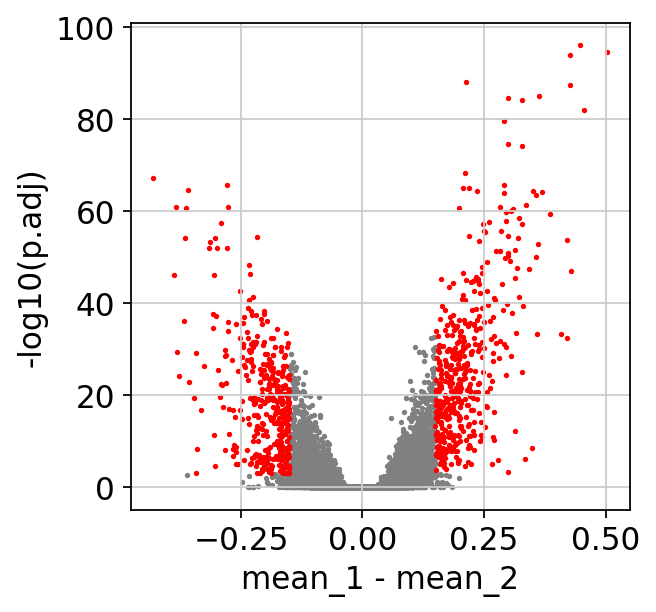

In [3]:
import multiome.marker_discovery as marker_discovery
stat_df = pd.read_csv('10X_CD4T.markers.csv',index_col=0)
stat_df = marker_discovery.MarkerFilter(stat_df,
                                             min_pct_rna=0.1, min_pct_atac=0.05,
                                             mean_diff=0.15, p_cutoff=1e-3,
                                             plot=True)

In [4]:
import multiome.functional_anno as functional_anno
motif_peaks = functional_anno.motif_summary(peak_file='homer/CD4T.peaks.bed',
                                            homer_dir='homer/homer_CD4T/',
                                            motif_index=2, ref_genome='hg38',
                                            homer_path='/mnt/atlas_local/chaozhong/data/homer/')


	Position file = homer/CD4T.peaks.bed
	Genome = hg38
	Output Directory = homer/homer_CD4T/
	Will find motif(s) in homer/homer_CD4T/knownResults/known2.motif
	Fragment size set to 200
	Found mset for "human", will check against vertebrates motifs
	Peak/BED file conversion summary:
		BED/Header formatted lines: 554
		peakfile formatted lines: 0

	Peak File Statistics:
		Total Peaks: 554
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Background files for 200 bp fragments found.

	Extracting sequences from file: /mnt/atlas_local/chaozhong/data/homer/.//data/genomes/hg38///genome.fa
	Looking for peak sequences in a single file (/mnt/atlas_local/chaozhong/data/homer/.//data/genomes/hg38///genome.fa)
	Extracting 57 sequences from chr1
	Extracting 23 sequences from chr10
	Extracting 35 sequences from

HOMER finished successfully! Motif related peaks will be loaded and returned.



	Cleaning up tmp files...



In [5]:
stat_df['peaks'] = stat_df['name'].str.split('_').str[1]
stat_df['genes'] = stat_df['name'].str.split('_').str[0]

gp_df = stat_df.loc[stat_df['peaks'].isin(motif_peaks['peaks']),['genes','peaks']].copy()

gp_df.index = gp_df['peaks']
gp_df.shape

(122, 2)

In [6]:
gp_df['genes'].to_csv('RUNX1_genes.txt',index=False, header=False)